In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import data_catalog
import tseries_mod
import esmlab_wrap

In [2]:
data_catalog.set_catalog('experiments')

active catalog: experiments


In [3]:
varnames = ['FG_CO2', 'FG_ALT_CO2', 'POC_FLUX_100m']

In [4]:
experiment = 'historical-waccm'
ds_expr_ann = tseries_mod.tseries_get_vars(varnames, 'ocn', experiment, freq='ann')
# print(ds_expr_ann)

In [5]:
# load Dataset for corresponding parent_experiment
parent_experiment = data_catalog.find_in_index(experiment=experiment).parent_experiment.unique()[0]
print(parent_experiment)
ds_parent_ann = tseries_mod.tseries_get_vars(varnames, 'ocn', parent_experiment, freq='ann')
# print(ds_parent_ann)

piControl-waccm


In [6]:
# add FG_ANTH_CO2 to datasets
for ds in [ds_expr_ann, ds_parent_ann]:
    ds['FG_ANTH_CO2'] = ds['FG_CO2'] - ds['FG_ALT_CO2']
# print(ds_expr_ann)
# print(ds_parent_ann)
varnames.append('FG_ANTH_CO2')

In [7]:
# construct year range of parent_experiment to use for detrending
branch_years = data_catalog.find_in_index(experiment=experiment).parent_branch_year.unique()
yr_lo = branch_years.min() - 50
yyyymmdd_lo = str(int(yr_lo)).zfill(4)+'-01-01'
yr_hi = branch_years.max() + 50 + len(ds_expr_ann.time)
yyyymmdd_hi = str(int(yr_hi)).zfill(4)+'-01-01'
print((yyyymmdd_lo, yyyymmdd_hi))

('0006-01-01', '0285-01-01')


In [8]:
# compute parent_experiment mean, for detrending
ds_parent_ann_slice_mean = ds_parent_ann.sel(time=slice(yyyymmdd_lo, yyyymmdd_hi)).mean(dim='time')
print(ds_parent_ann_slice_mean.FG_CO2)
print(ds_parent_ann_slice_mean.FG_ALT_CO2)
print(ds_parent_ann_slice_mean.FG_ANTH_CO2)
print(ds_parent_ann_slice_mean.POC_FLUX_100m)

<xarray.DataArray 'FG_CO2' (region: 7)>
array([-0.06194963,  0.21353363, -0.18290153,  0.5123201 , -1.0263826 ,
        0.36979094,  0.26522332], dtype=float32)
Coordinates:
  * region   (region) object 'Global' ... 'NH_high_lat (49N-90N)'
Attributes:
    long_name:     Integrated DIC Surface Gas Flux
    units:         Pg yr-1
    grid_loc:      2110
    cell_methods:  time: mean
<xarray.DataArray 'FG_ALT_CO2' (region: 7)>
array([-0.05766982,  0.21660642, -0.1824191 ,  0.51436853, -1.0249137 ,
        0.36949152,  0.26580375], dtype=float32)
Coordinates:
  * region   (region) object 'Global' ... 'NH_high_lat (49N-90N)'
Attributes:
    long_name:     Integrated DIC Surface Gas Flux, Alternative CO2
    units:         Pg yr-1
    grid_loc:      2110
    cell_methods:  time: mean
<xarray.DataArray 'FG_ANTH_CO2' (region: 7)>
array([-0.00427982, -0.0030728 , -0.00048254, -0.00204808, -0.00146824,
        0.00029957, -0.00058053], dtype=float32)
Coordinates:
  * region   (region) object 'Gl

In [9]:
ds_expr_ann_detrended = ds_expr_ann - ds_parent_ann_slice_mean

In [10]:
# add cummulate flux vars to datasets
for ds in [ds_expr_ann, ds_expr_ann_detrended]:
    for varname in varnames:
        da = ds[varname].cumsum(dim='time', keep_attrs=True)
        da.name = varname+'_CUM'
        da.attrs['units'] = 'Pg'
        ds[da.name] = da

# print(ds_expr_ann)
# print(ds_expr_ann_detrended)

array([126.95192, 128.13191, 130.11604], dtype=float32)

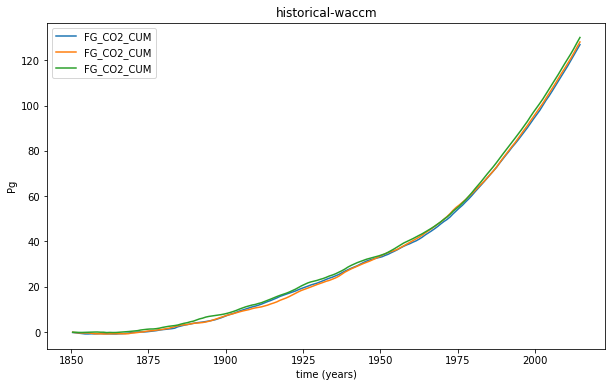

In [11]:
tseries_mod.tseries_plot_1ds(ds_expr_ann, ['FG_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann['FG_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([132.565  , 132.55609, 132.80553], dtype=float32)

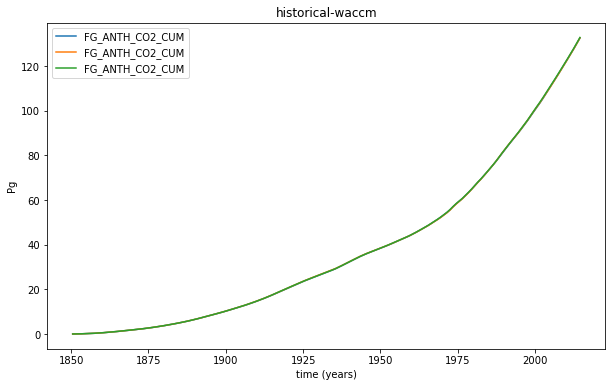

In [12]:
tseries_mod.tseries_plot_1ds(ds_expr_ann, ['FG_ANTH_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann['FG_ANTH_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([137.17365, 138.35359, 140.33772], dtype=float32)

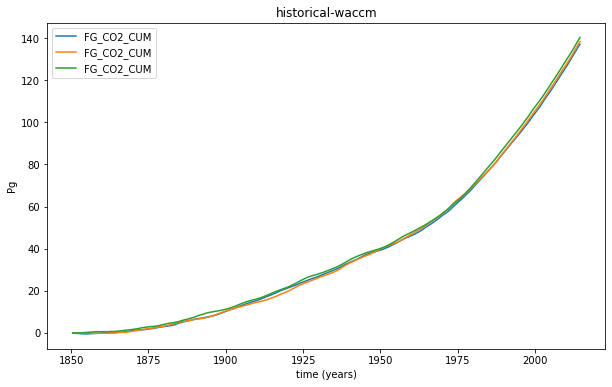

In [13]:
tseries_mod.tseries_plot_1ds(ds_expr_ann_detrended, ['FG_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann_detrended['FG_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([133.27118, 133.26225, 133.51172], dtype=float32)

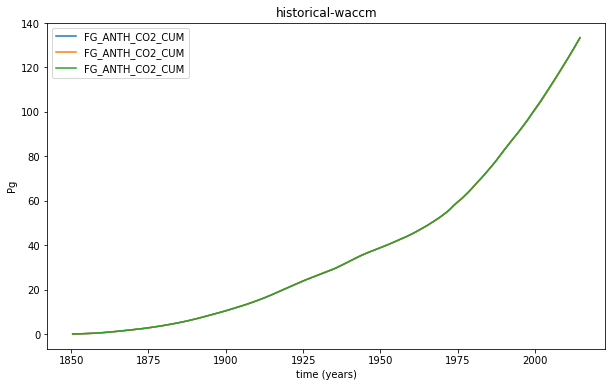

In [14]:
tseries_mod.tseries_plot_1ds(ds_expr_ann_detrended, ['FG_ANTH_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann_detrended['FG_ANTH_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([3.902426 , 5.0913095, 6.825998 ], dtype=float32)

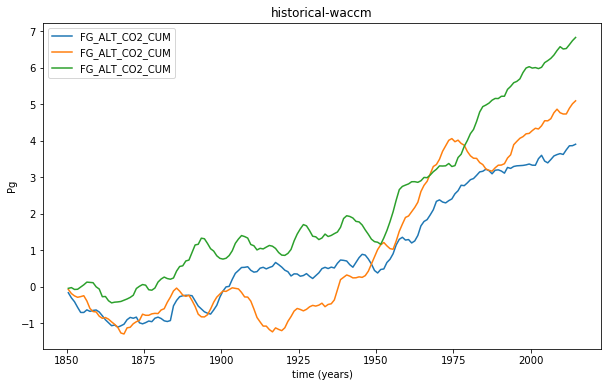

In [15]:
tseries_mod.tseries_plot_1ds(ds_expr_ann_detrended, ['FG_ALT_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann_detrended['FG_ALT_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([-5.613094 , -4.4242105, -2.6895232], dtype=float32)

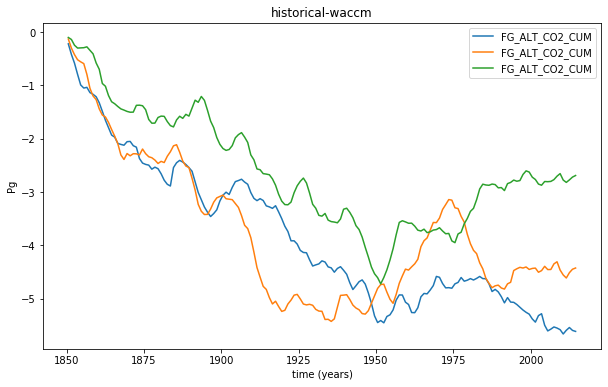

In [16]:
tseries_mod.tseries_plot_1ds(ds_expr_ann, ['FG_ALT_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann['FG_ALT_CO2_CUM'].sel(region='Global').isel(time=-1).values

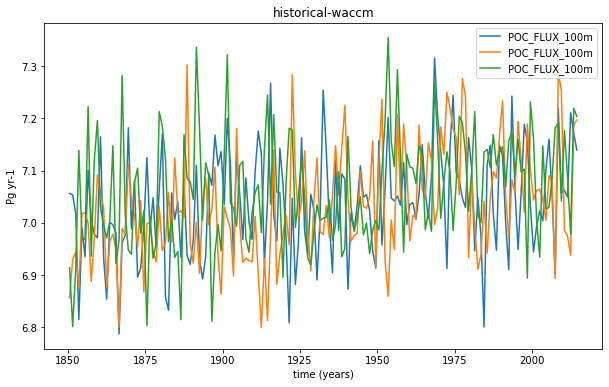

In [17]:
tseries_mod.tseries_plot_1ds(ds_expr_ann, ['POC_FLUX_100m'], title=experiment, region_val='Global')

array([ 6.5341263,  5.5162034, 10.629074 ], dtype=float32)

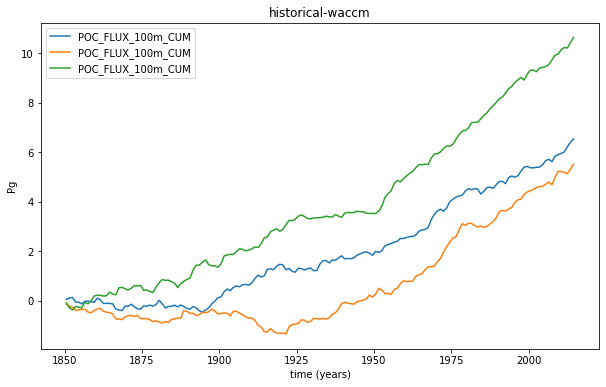

In [18]:
tseries_mod.tseries_plot_1ds(ds_expr_ann_detrended, ['POC_FLUX_100m_CUM'], title=experiment, region_val='Global')
ds_expr_ann_detrended['POC_FLUX_100m_CUM'].sel(region='Global').isel(time=-1).values